# Variational Auto-Encoder (VAE)

Based on this [paper](https://arxiv.org/pdf/1312.6114.pdf). A very good blog post about the paper [here](http://kvfrans.com/variational-autoencoders-explained/).

<img src="http://kvfrans.com/content/images/2016/08/vae.jpg" alt="vae" style="width: 800px;"/>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
# Hyperparameters
learning_rate = 1e-3
training_steps = int(25e3)
batch_size = 64

# Network parameters
input_size = 784 # MNIST images are 28x28
hidden_size = 512
latent_size = 2

## Model

In [3]:
# Fully connected layer
def fully_connected(name, x, W_shape, b_shape, reuse=False):
    with tf.variable_scope(name, reuse=reuse):
        W = tf.get_variable("W", W_shape)
        b = tf.get_variable("b", b_shape)
    return tf.add(tf.matmul(x, W), b)

# Input placeholder
input_images = tf.placeholder(tf.float32, shape=[None, input_size])

# Encoder
encoder = tf.nn.tanh(fully_connected("encoder", input_images, [input_size, hidden_size], [hidden_size]))
# Mean vector
z_mean = fully_connected("z_mean", encoder, [hidden_size, latent_size], [latent_size])
# Log variance vector
z_logvar = fully_connected("z_std", encoder, [hidden_size, latent_size], [latent_size])

# Sample epsilon from a standard normal distribution
eps = tf.random_normal(tf.shape(z_logvar), dtype=tf.float32, mean=0., stddev=1.0)
# z = mean + standard deviation * epsilon
z = z_mean + tf.exp(z_logvar / 2) * eps

# Decoder
decoder = tf.nn.tanh(fully_connected("decoder", z, [latent_size, hidden_size], [hidden_size]))
decoder = tf.nn.sigmoid(fully_connected("decoder_2", decoder, [hidden_size, input_size], [input_size]))

Our loss is composed of the reconstruction loss as well as the KL divergence between the distribution of our latent variables and a unit Gaussian distribution.

In [4]:
# Loss
# Cross entropy term
cross_entropy = input_images * tf.log(decoder) + (1 - input_images) * tf.log(1 - decoder)
cross_entropy = -1 * tf.reduce_sum(cross_entropy, axis=1)
# KL divergence term
KL = 1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar)
KL = -0.5 * tf.reduce_sum(KL, axis=1)
# Average of both terms
loss = tf.reduce_mean(cross_entropy + KL)

# RMSProp optimizer
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# Initializer
init = tf.global_variables_initializer()

## Training

For training, we will tell our network to reconstruct the original images that are passed in, and try to minimize our loss.

In [5]:
# New session
sess = tf.Session()

# Initialize
sess.run(init)

for i in range(training_steps):
    # Next batch of training data
    batch_x, _ = mnist.train.next_batch(batch_size)
    
    # Optimization step
    _, l = sess.run([optimizer, loss], feed_dict={input_images: batch_x})
    
    # Output loss every 1000 steps
    if i % 1000 == 0:
        print('Step %i, Loss: %f' % (i, l))

Step 0, Loss: 547.564392
Step 1000, Loss: 177.618561
Step 2000, Loss: 180.522797
Step 3000, Loss: 177.307831
Step 4000, Loss: 168.814301
Step 5000, Loss: 167.981522
Step 6000, Loss: 161.170502
Step 7000, Loss: 176.502777
Step 8000, Loss: 165.864777
Step 9000, Loss: 156.070435
Step 10000, Loss: 167.225906
Step 11000, Loss: 178.624329
Step 12000, Loss: 168.543961
Step 13000, Loss: 160.817734
Step 14000, Loss: 162.417877
Step 15000, Loss: 150.117554
Step 16000, Loss: 154.255920
Step 17000, Loss: 159.211304
Step 18000, Loss: 159.453384
Step 19000, Loss: 164.521606
Step 20000, Loss: 151.279251
Step 21000, Loss: 158.313034
Step 22000, Loss: 153.483398
Step 23000, Loss: 147.643951
Step 24000, Loss: 154.888031


## Generation

For generating new images of numbers, we will remove the encoding layers and replace the input to our decoding layers with noisy input that we randomly generate.

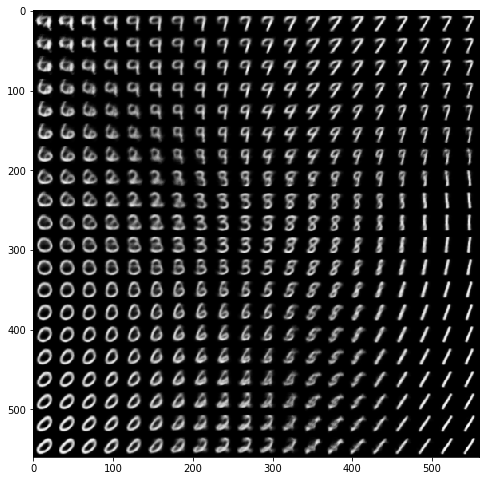

In [6]:
# Input noise placeholder
input_noise = tf.placeholder(tf.float32, shape=[None, latent_size])

# Decoder, reusing weights from training
decoder_test = tf.nn.tanh(fully_connected("decoder", input_noise, [latent_size, hidden_size], [hidden_size], reuse=True))
decoder_test = tf.nn.sigmoid(fully_connected("decoder_2", decoder_test, [hidden_size, input_size], [input_size], reuse=True))

# Generating the learned 2D data manifold as in Appendix A of the paper
# Building a manifold of generated digits
n = 20 # nxn digits
x_axis = np.linspace(-3, 3, n) # n evenly spaced numbers between the interval
y_axis = np.linspace(-3, 3, n)

# Generate image from noisy input
figure = np.empty((28 * n, 28 * n))
for i, xi in enumerate(x_axis):
    for j, yi in enumerate(y_axis):
        z_gen = np.array([[xi, yi]])
        # Feed the input to the decoder
        x_gen = sess.run(decoder_test, feed_dict={input_noise: z_gen})
        # Reshape the output to a 28x28 image
        x_gen = x_gen[0].reshape(28, 28)
        figure[i * 28:(i + 1) * 28,
               j * 28:(j + 1) * 28] = x_gen

# Plot
plt.figure(figsize=(8, 10))
plt.imshow(figure, origin="upper", cmap="gray")
plt.show()

Note that the reconstructed samples below are blurry, due to VAE's Gaussian piror. This is one of the drawbacks of VAE.

Original Images


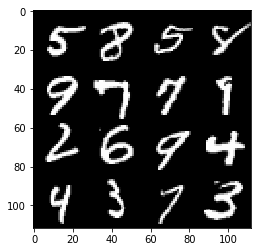

Reconstructed Images


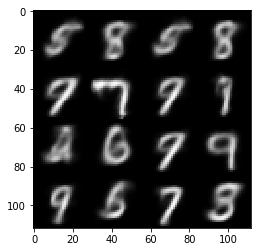

In [7]:
# Encode and decode images from test set and visualize their reconstruction.
n = 4
canvas_orig = np.empty((28 * n, 28 * n))
canvas_recon = np.empty((28 * n, 28 * n))
for i in range(n):
    # MNIST test set
    batch_x, _ = mnist.test.next_batch(n)
    # Encode and decode the digit image
    recon = sess.run(decoder, feed_dict={input_images: batch_x})
    
    # Display original images
    for j in range(n):
        # Draw the generated digits
        canvas_orig[i * 28:(i + 1) * 28,
                    j * 28:(j + 1) * 28] = batch_x[j].reshape([28, 28])
    # Display reconstructed images
    for j in range(n):
        # Draw the generated digits
        canvas_recon[i * 28:(i + 1) * 28,
                     j * 28:(j + 1) * 28] = recon[j].reshape([28, 28])

print("Original Images")     
plt.figure(figsize=(n, n))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize=(n, n))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()